# Population Density per County in Kenya

This is an example using the Space2Stats API to generate a map of population density across counties in Kenya.

In [1]:
from typing import Dict

import numpy as np
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from lonboard import Map, ScatterplotLayer
from geojson_pydantic import Feature, Polygon

import json
from tqdm.notebook import tqdm
import folium as flm

In [2]:
BASE_URL = "https://space2stats.ds.io"
FIELDS_ENDPOINT = f"{BASE_URL}/fields"
SUMMARY_ENDPOINT = f"{BASE_URL}/summary"

In [3]:
response = requests.get(FIELDS_ENDPOINT)
if response.status_code != 200:
    raise Exception(f"Failed to get fields: {response.text}")

available_fields = response.json()
print("Available Fields:", available_fields)

Available Fields: ['sum_pop_2020', 'ogc_fid', 'sum_pop_f_0_2020', 'sum_pop_f_10_2020', 'sum_pop_f_15_2020', 'sum_pop_f_1_2020', 'sum_pop_f_20_2020', 'sum_pop_f_25_2020', 'sum_pop_f_30_2020', 'sum_pop_f_35_2020', 'sum_pop_f_40_2020', 'sum_pop_f_45_2020', 'sum_pop_f_50_2020', 'sum_pop_f_55_2020', 'sum_pop_f_5_2020', 'sum_pop_f_60_2020', 'sum_pop_f_65_2020', 'sum_pop_f_70_2020', 'sum_pop_f_75_2020', 'sum_pop_f_80_2020', 'sum_pop_m_0_2020', 'sum_pop_m_10_2020', 'sum_pop_m_15_2020', 'sum_pop_m_1_2020', 'sum_pop_m_20_2020', 'sum_pop_m_25_2020', 'sum_pop_m_30_2020', 'sum_pop_m_35_2020', 'sum_pop_m_40_2020', 'sum_pop_m_45_2020', 'sum_pop_m_50_2020', 'sum_pop_m_55_2020', 'sum_pop_m_5_2020', 'sum_pop_m_60_2020', 'sum_pop_m_65_2020', 'sum_pop_m_70_2020', 'sum_pop_m_75_2020', 'sum_pop_m_80_2020', 'sum_pop_m_2020', 'sum_pop_f_2020']


## Boundaries 
Source from GeoBoundaries (until we have WB file)

In [4]:
iso3 = 'KEN'
adm = 'ADM1'
url = f'https://www.geoboundaries.org/api/current/gbOpen/{iso3}/{adm}/'
res = requests.get(url).json()
adm = gpd.read_file(res['gjDownloadURL'])

<Axes: >

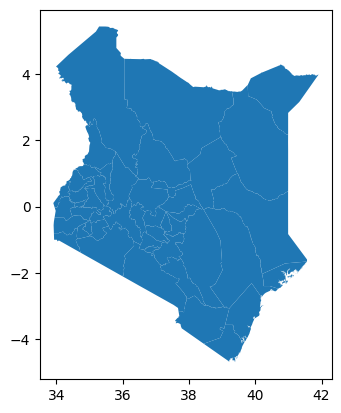

In [5]:
adm = adm.explode(index_parts=False)
adm.reset_index(inplace=True, drop=True)
adm.plot()

In [6]:
AOIModel = Feature[Polygon, Dict]

In [7]:
geojson_str = adm.to_json()
adm_geojson = json.loads(geojson_str)
adm_features = adm_geojson['features']
len(adm_features)

165

In [8]:
def get_intersection(admin_shp, hex_shp):
    ''' get fraction of hex_shp that is inside admin_shp
    '''
    return(admin_shp.intersection(hex_shp).area / hex_shp.area)

In [9]:
gdfs = [] 
for feature in tqdm(adm_features):

    # I think this validates the geojson
    feat = AOIModel(**feature)
    
    # Define the Request Payload
    request_payload = {
        "aoi": feature,
        "spatial_join_method": "centroid",
        "fields": ["sum_pop_2020"], 
        "geometry": "polygon"
    }
    
    # Get Summary Data
    response = requests.post(SUMMARY_ENDPOINT, json=request_payload)
    if response.status_code != 200:
        raise Exception(f"Failed to get summary: {response.text}")
        
    summary_data = response.json()
    if summary_data == []: # Error needs to be added to API
        print(f"Failed to get summary for {feature['id']}")
        continue

    df = pd.DataFrame(summary_data)
    df['adm_id'] = int(feature['id'])
    df['adm_name'] = feature['properties']['shapeName']

    df['geometry'] = df['geometry'].apply(lambda geom: shape(geom))
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    adm_shape = shape(feature['geometry'])
    gdf['intersect_pct'] = gdf['geometry'].apply(lambda x: get_intersection(adm_shape, x))
    
    gdfs.append(gdf)

  0%|          | 0/165 [00:00<?, ?it/s]

Failed to get summary for 47
Failed to get summary for 48
Failed to get summary for 49
Failed to get summary for 50
Failed to get summary for 51
Failed to get summary for 52
Failed to get summary for 53
Failed to get summary for 54
Failed to get summary for 56
Failed to get summary for 57
Failed to get summary for 58
Failed to get summary for 59
Failed to get summary for 60
Failed to get summary for 61
Failed to get summary for 62
Failed to get summary for 63
Failed to get summary for 64
Failed to get summary for 65
Failed to get summary for 66
Failed to get summary for 67
Failed to get summary for 68
Failed to get summary for 69
Failed to get summary for 70
Failed to get summary for 71
Failed to get summary for 72
Failed to get summary for 73
Failed to get summary for 74
Failed to get summary for 75
Failed to get summary for 76
Failed to get summary for 77
Failed to get summary for 78
Failed to get summary for 79
Failed to get summary for 80
Failed to get summary for 81
Failed to get 

In [10]:
gdf = pd.concat(gdfs)
gdf.head()

hex_id                                           geometry  \
0  866a4a407ffffff  POLYGON ((34.8631 4.35157, 34.87544 4.38232, 3...   
1  866a4a417ffffff  POLYGON ((35.05966 4.43462, 35.07196 4.46533, ...   
2  866a4a41fffffff  POLYGON ((36.39678 2.18708, 36.40895 2.21847, ...   
3  866a4a427ffffff  POLYGON ((34.62572 2.93777, 34.63817 2.96904, ...   
4  866a4a437ffffff  POLYGON ((36.21001 2.04327, 36.22222 2.07472, ...   

   sum_pop_2020  adm_id adm_name  intersect_pct  
0    554.655021       0  Turkana        1.00000  
1    207.977046       0  Turkana        1.00000  
2    637.218817       0  Turkana        1.00000  
3    948.876730       0  Turkana        0.70683  
4    112.805780       0  Turkana        1.00000

In [11]:
gdf['hex_id'].duplicated().sum()

np.int64(0)

In [12]:
gdf.sort_values(by='intersect_pct', inplace=True, ascending=False)
# gdf.drop_duplicates(subset='hex_id', keep='first', inplace=True)

In [13]:
len(gdf.loc[gdf['sum_pop_2020']<0])

179

In [14]:
gdf = gdf.loc[gdf['sum_pop_2020']>=0].copy()

## Map of Hexagons

### Folium

This method is slow but there is good support for legend and classification schemes.

In [15]:
# m = gdf.explore(
#     column='sum_pop_2020',
#     tooltip='sum_pop_2020',
#     cmap='YlGnBu',
#     legend=True,
#     scheme='naturalbreaks',
#     legend_kwds=dict(colorbar=True, caption='Population', interval=False),
#     style_kwds=dict(weight=0, fillOpacity=0.8),
#     name='Population by Hexagon'
# )
# flm.LayerControl('topright', collapsed = False).add_to(m)
# m

### Lonboard

Much faster! TBD how to publish these.

In [16]:
from lonboard import Map, PolygonLayer, Map
from palettable.colorbrewer.sequential import YlGnBu_7
from mapclassify import JenksCaspall

In [17]:
# layer = SolidPolygonLayer.from_geopandas(zones_interpolated, opacity=0.2)
jc = JenksCaspall(
    gdf["sum_pop_2020"],
    k=7
)

color_list = YlGnBu_7.colors
colors = []
for color in jc.yb:
    colors.append(color_list[color])

# From demo
# breaks = [0, 1, 1000, 10000, 50000, 100000, 200000, gdf["sum_pop_2020"].max()]
# Function to assign colors based on custom bins
# def assign_color(value, breaks, colors):
#     for i in range(len(breaks) - 1):
#         if breaks[i] <= value < breaks[i + 1]:
#             return colors[i]
#     return colors[-1]  # In case value exceeds all breaks

# Map sum_pop_2020 values to colors using the custom function
# gdf['color'] = gdf["sum_pop_2020"].apply(lambda x: assign_color(x, breaks, colors))
# colors = np.uint8(gdf['color'].tolist())

layer = PolygonLayer.from_geopandas(gdf, get_fill_color=np.uint8(colors))

m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x0000017BFFD39900>
[
  [
  …

## Admin Summary

Sum by district and calculate population density.

In [18]:
adm_pop = gdf.groupby('adm_id')['sum_pop_2020'].sum()
adm_zs = adm.join(adm_pop)

In [19]:
utm = 'EPSG:32737'
adm_zs = adm_zs.to_crs(utm)

In [20]:
adm_zs.loc[:, 'area_sqkm'] = adm_zs.area / 1e6
adm_zs.loc[:, "pop_density"] = adm_zs["sum_pop_2020"] / adm_zs["area_sqkm"]

In [21]:
m = adm_zs.explore(
    column='pop_density',
    tooltip=['sum_pop_2020', 'pop_density', 'shapeName'],
    cmap='YlGnBu',
    legend=True,
    scheme='quantiles',
    legend_kwds=dict(colorbar=False, caption='Population', interval=False),
    style_kwds=dict(weight=0.5, fillOpacity=0.8, color='black'),
    name='Population Density by Admin Area'
)
flm.LayerControl('topright', collapsed = False).add_to(m)
m